In [1]:
import pandas as pd
import numpy as np
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

# make parent folder importable (if you need to import src modules)
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

print("Libraries loaded, project_root =", project_root)

Libraries loaded, project_root = C:\Users\kesha\Documents\it emailphishing


In [2]:
# Cell 2 — load cleaned dataset and show basic info
df = pd.read_csv("../data/clean_dataset.csv")
print("Dataset shape:", df.shape)

# numeric features (drop label)
numeric_features = df.drop(columns=["CLASS_LABEL"]).columns.tolist()
assert len(numeric_features) == 48, f"Expected 48 numeric features, found {len(numeric_features)}"

X = df[numeric_features]
y = df["CLASS_LABEL"]

print("Numeric features count:", len(numeric_features))
print("Sample feature names:", numeric_features[:10])


Dataset shape: (9581, 49)
Numeric features count: 48
Sample feature names: ['NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore', 'NumPercent']


In [3]:
# Cell 3 — load saved pipeline (the pipeline that contains a 'preprocessor' and 'model')
pipeline_path = "../models/best_tuned_model.joblib"
pipeline = joblib.load(pipeline_path)
print("Loaded pipeline from:", pipeline_path)
print("Pipeline steps:", pipeline.steps)


Loaded pipeline from: ../models/best_tuned_model.joblib
Pipeline steps: [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['NumDots', 'SubdomainLevel', 'PathLevel',
                                  'UrlLength', 'NumDash', 'NumDashInHostname',
                                  'AtSymbol', 'TildeSymbol', 'NumUnderscore',
                                  'NumPercent', 'NumQueryComponents',
                                  'NumAmpersand', 'NumHash', 'NumNumericChars',
                                  'NoHttps', 'RandomString', 'IpAddress',
                                  'DomainInSubdomains', 'DomainInPaths',
                                  'HttpsInHostname', 'HostnameLength',
                                  'PathLength', 'QueryLength',
                                  'DoubleSlashInPath', 'NumSensitiveWords',
                                  'EmbeddedBrandName', 'PctExtHyperlinks',
                                  'Pc

In [4]:
# Cell 4 — extract numeric transformer and RF model
preprocessor = pipeline.named_steps.get("preprocessor", None)
rf_model = pipeline.named_steps.get("model", None)

if preprocessor is None or rf_model is None:
    raise ValueError("Pipeline must contain 'preprocessor' and 'model' named steps.")

# Get numeric transformer from ColumnTransformer
# This assumes the ColumnTransformer used the name "num" for numeric transformer (as in the notebook)
num_transformer = preprocessor.named_transformers_.get("num", None)
if num_transformer is None:
    # show available transformers to debug
    print("Available transformers:", preprocessor.named_transformers_.keys())
    raise ValueError("ColumnTransformer does not have a 'num' transformer. Update the key accordingly.")

print("Numeric transformer and RF model extracted.")


Numeric transformer and RF model extracted.


In [5]:
# Cell 5 — create train/test split (same reproducible split used earlier)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train/Test shapes:", X_train.shape, X_test.shape)


Train/Test shapes: (7664, 48) (1917, 48)


In [6]:
# Cell 6 — sample and transform numeric features (safe & fast)
# We'll sample up to 300 rows to keep SHAP fast
sample_size = min(300, X_test.shape[0])
sample_idx = np.random.RandomState(42).choice(X_test.index, size=sample_size, replace=False)
X_sample_raw = X_test.loc[sample_idx]

# transform numeric features using the numeric transformer (e.g. StandardScaler)
X_sample_num = num_transformer.transform(X_sample_raw[numeric_features])

print("X_sample_num shape:", X_sample_num.shape)


X_sample_num shape: (300, 48)


In [7]:
# Cell 7 — SHAP explainer and values (TreeExplainer for RandomForest)
explainer = shap.TreeExplainer(rf_model)

# compute shap values (for classification RandomForest, shap_values is list [class0, class1])
shap_values = explainer.shap_values(X_sample_num)

# pick class 1 (phishing) shap values
if isinstance(shap_values, list) and len(shap_values) > 1:
    sv = shap_values[1]
else:
    # some shap versions return array with shape (n_samples, n_features)
    sv = shap_values

print("SHAP values shape:", sv.shape, "X_sample_num shape:", X_sample_num.shape)

# If shapes disagree on rows/cols, align safely by trimming to min dims
min_rows = min(sv.shape[0], X_sample_num.shape[0])
min_cols = min(sv.shape[1], X_sample_num.shape[1], len(numeric_features))

sv = sv[:min_rows, :min_cols]
X_fixed = X_sample_num[:min_rows, :min_cols]
fn_fixed = numeric_features[:min_cols]

print("After aligning: SHAP shape:", sv.shape, "X_fixed shape:", X_fixed.shape, "num features used:", len(fn_fixed))


SHAP values shape: (300, 48, 2) X_sample_num shape: (300, 48)
After aligning: SHAP shape: (300, 48, 2) X_fixed shape: (300, 48) num features used: 48


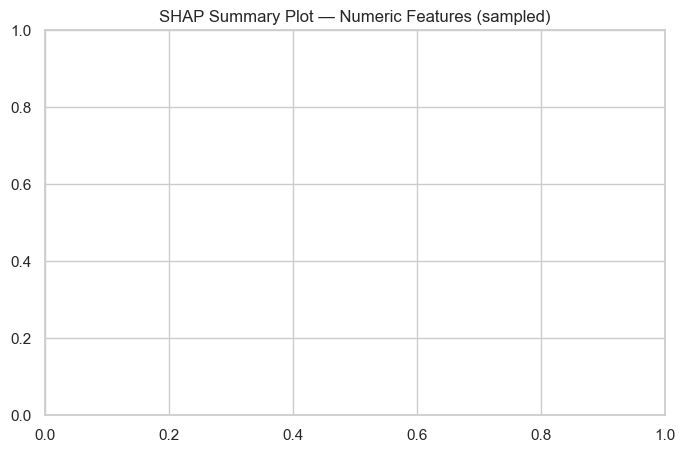

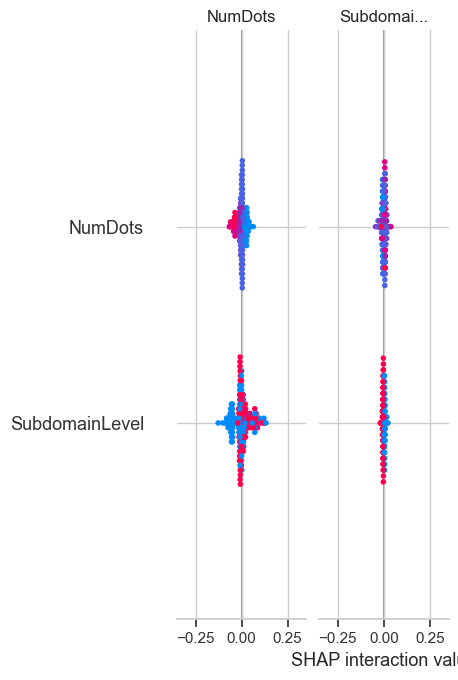

Saved: ../results/explainability/shap_summary.png


<Figure size 800x500 with 0 Axes>

In [8]:
# Cell 8 — SHAP summary plot (numeric only)
plt.title("SHAP Summary Plot — Numeric Features (sampled)")
shap.summary_plot(sv, X_fixed, feature_names=fn_fixed)
# save the plot
os.makedirs("../results/explainability", exist_ok=True)
plt.savefig("../results/explainability/shap_summary.png", dpi=150, bbox_inches="tight")
print("Saved: ../results/explainability/shap_summary.png")


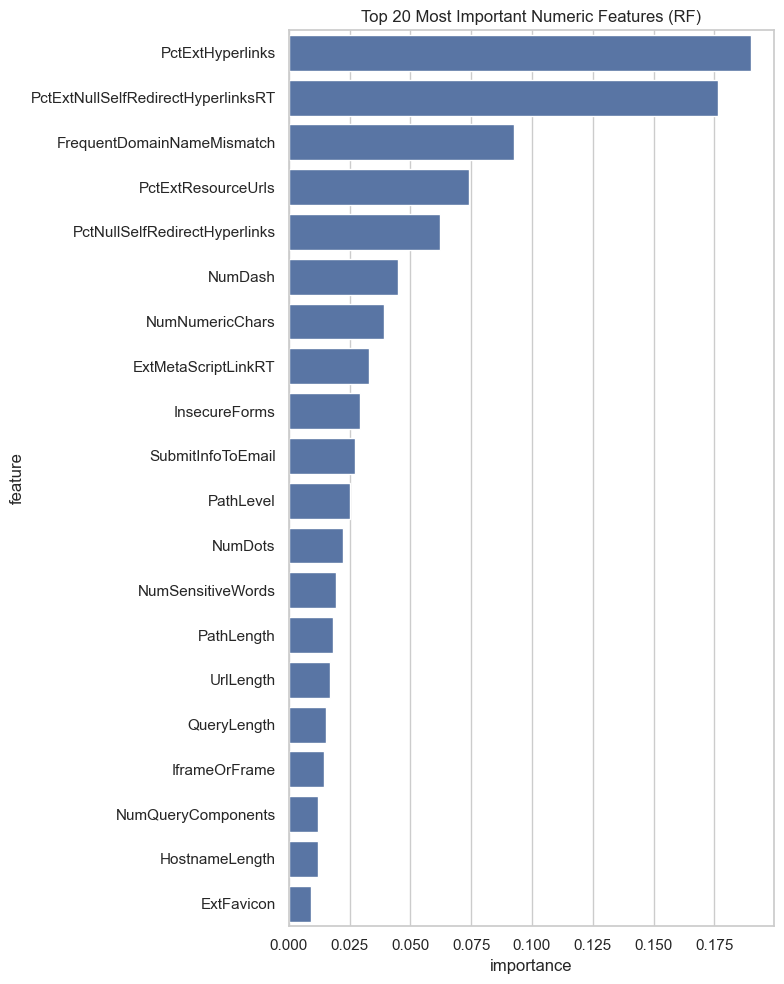

Saved: ../results/explainability/top_numeric_features.png


In [9]:
# Cell 9 — feature importance (RandomForest built-in)
import pandas as pd
import seaborn as sns

importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({"feature": numeric_features, "importance": importances}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(data=feat_imp.head(20), x="importance", y="feature")
plt.title("Top 20 Most Important Numeric Features (RF)")
plt.tight_layout()
plt.savefig("../results/explainability/top_numeric_features.png", dpi=150)
plt.show()
print("Saved: ../results/explainability/top_numeric_features.png")


In [10]:
# Cell 10 — suspicious-token highlighter (text helper)
import re

SUSPICIOUS = ["verify", "click", "login", "update", "password", "bank",
              "urgent", "suspended", "invoice", "limited", "confirm"]

def highlight_suspicious_tokens(email_text: str) -> str:
    words = email_text.split()
    out = []
    for w in words:
        clean = re.sub(r"[^\w]", "", w).lower()
        if clean in SUSPICIOUS:
            out.append(f"<<{w}>>")
        else:
            out.append(w)
    return " ".join(out)

# quick test
_print = "Your account has been suspended. Click here to verify."
print("Highlighted test:", highlight_suspicious_tokens(_print))


Highlighted test: Your account has been <<suspended.>> <<Click>> here to <<verify.>>


In [11]:
# pick one example
example_idx = X_test.index[0]
example_row = X_test.loc[example_idx]

print("Example row created.")

Example row created.


In [12]:
from src.explain import highlight_suspicious_tokens, explain_row_numeric
explanation = explain_row_numeric(
    pipeline,
    example_row,
    numeric_features,
    top_n=6
)
print(explanation)


{'prediction': 1, 'probability': 0.995, 'top_contributors': [{'feature': 'NumUnderscore', 'shap_value': -0.03292701968436145}, {'feature': 'NumPercent', 'shap_value': 0.032927019684361424}, {'feature': 'PctExtHyperlinks', 'shap_value': -0.026642390456498247}, {'feature': 'PctExtResourceUrls', 'shap_value': 0.02664239045649817}, {'feature': 'NumDash', 'shap_value': -0.01040867654748506}, {'feature': 'NumDashInHostname', 'shap_value': 0.010408676547484922}]}


In [13]:
import json
import os

os.makedirs("../results/explainability", exist_ok=True)

with open("../results/explainability/email_explanation_example.json", "w", encoding="utf8") as f:
    json.dump(report, f, indent=2)

print("Saved explanation JSON to ../results/explainability/email_explanation_example.json")


NameError: name 'report' is not defined

In [14]:
from src.explain import explain_email_text

email = """
Your account has been suspended. Verify immediately:
http://malicious-example.com/reset?user=123
"""

report = explain_email_text(pipeline, email, numeric_features)

print(report)


KeyError: 'NumLetters'